# Setup and Installations

In [1]:
import os
import subprocess

# Define the setup script path
setup_script_path = 'setup_notebook.sh'

# Run the setup script
subprocess.call(['bash', setup_script_path])

# Print environment setup confirmation
print("Environment setup complete.")


no change     /Users/md/anaconda3/condabin/conda
no change     /Users/md/anaconda3/bin/conda
no change     /Users/md/anaconda3/bin/conda-env
no change     /Users/md/anaconda3/bin/activate
no change     /Users/md/anaconda3/bin/deactivate
no change     /Users/md/anaconda3/etc/profile.d/conda.sh
no change     /Users/md/anaconda3/etc/fish/conf.d/conda.fish
no change     /Users/md/anaconda3/shell/condabin/Conda.psm1
no change     /Users/md/anaconda3/shell/condabin/conda-hook.ps1
no change     /Users/md/anaconda3/lib/python3.11/site-packages/xontrib/conda.xsh
no change     /Users/md/anaconda3/etc/profile.d/conda.csh
no change     /Users/md/.zshrc
No action taken.
Channels:
 - defaults
Platform: osx-arm64
Solving environment: ...working... done

# All requested packages already installed.
Remove existing environment (y/[n])? 



CondaSystemExit: Exiting.



Num GPUs Available:  1
Setup complete. Ready to run notebooks.
Environment setup complete.


In [2]:
import os
import sys

import gymnasium as gym
from stable_baselines3.dqn.dqn import DQN
print("SUMO_HOME:", os.environ.get("SUMO_HOME"))

SUMO_HOME: /opt/homebrew/opt/sumo/share/sumo


In [3]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found. Using CPU.")

In [4]:
import os
import sumo_rl

# Get the path to the installed sumo-rl package
sumo_rl_path = os.path.dirname(sumo_rl.__file__)
print("Path to sumo-rl package:", sumo_rl_path)

# Optional: List the contents of the package directory
for root, dirs, files in os.walk(sumo_rl_path):
    for file in files:
        print(os.path.join(root, file))


Path to sumo-rl package: /Users/md/anaconda3/lib/python3.11/site-packages/sumo_rl
/Users/md/anaconda3/lib/python3.11/site-packages/sumo_rl/__init__.py
/Users/md/anaconda3/lib/python3.11/site-packages/sumo_rl/util/__init__.py
/Users/md/anaconda3/lib/python3.11/site-packages/sumo_rl/util/gen_route.py
/Users/md/anaconda3/lib/python3.11/site-packages/sumo_rl/util/__pycache__/gen_route.cpython-311.pyc
/Users/md/anaconda3/lib/python3.11/site-packages/sumo_rl/util/__pycache__/__init__.cpython-311.pyc
/Users/md/anaconda3/lib/python3.11/site-packages/sumo_rl/agents/ql_agent.py
/Users/md/anaconda3/lib/python3.11/site-packages/sumo_rl/agents/__init__.py
/Users/md/anaconda3/lib/python3.11/site-packages/sumo_rl/agents/__pycache__/ql_agent.cpython-311.pyc
/Users/md/anaconda3/lib/python3.11/site-packages/sumo_rl/agents/__pycache__/__init__.cpython-311.pyc
/Users/md/anaconda3/lib/python3.11/site-packages/sumo_rl/__pycache__/__init__.cpython-311.pyc
/Users/md/anaconda3/lib/python3.11/site-packages/sumo

# Environment Setup

In [5]:
if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")

import traci
from sumo_rl import SumoEnvironment

# Training the DQN Agent

# Setup Timestamp for Training

In [5]:
from datetime import datetime
import pytz

jerusalem_tz = pytz.timezone('Asia/Jerusalem')

jerusalem_time = datetime.now(jerusalem_tz)

# Format the timestamp
timestamp = jerusalem_time.strftime("%Y%m%d_%H%M%S")

### Run the following code to get the path to the SUMO remote server


In [7]:
package_path = os.path.dirname(sumo_rl.__file__)
sumo_cfg_path = os.path.join(package_path, "nets/single-intersection/single-intersection.sumocfg")

# Use the package path in your command
if package_path:
    cmd = f"sumo-gui -c {sumo_cfg_path} --remote-port 65533"
    print("Run the following command in the terminal to start the SUMO server:")
    print(cmd)
else:
    print("sumo-rl package not found. Make sure it is installed.")

Run the following command in the terminal to start the SUMO server:
sumo-gui -c /Users/md/anaconda3/lib/python3.11/site-packages/sumo_rl/nets/single-intersection/single-intersection.sumocfg --remote-port 65533


In [8]:
import os
import matplotlib.pyplot as plt

from sumo_rl import SumoEnvironment
from stable_baselines3 import DQN
import traci
import imageio

def capture_screenshot(output_path, episode, step):
    file_name = f"episode_{episode}_step_{step}.png"
    file_path = os.path.join(output_path, file_name)
    traci.gui.screenshot(traci.gui.DEFAULT_VIEW, file_path)

def train_and_predict(env, model, episodes, save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    rewards_per_episode = []  # List to store rewards for each episode

    for episode in range(episodes):
        obs, info = env.reset()
        done = False
        step = 0
        total_reward = 0  # Variable to store total reward for the episode
        while step < 3600:
            action, _states = model.predict(obs)
            results = env.step(action)
            if len(results) == 5:
                obs, rewards, done, _, info = results
                if done:
                    print(f"DONE: {done}")
            else:
                raise ValueError(f"Expected 5 values from env.step(), got {len(results)}")
            total_reward += rewards  # Accumulate rewards
            # Capture and save the environment state every 10 steps
            if step % 10 == 0:
                capture_screenshot(save_path, episode, step)
            step += 1
        rewards_per_episode.append(total_reward)  # Append total reward for this episode

    model.save('savedAgent/single-intersection/dqn')

    # Plot the rewards
    plt.plot(range(1, episodes + 1), rewards_per_episode, marker='o')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Improvement in Total Reward over Episodes')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    print("Connecting to SUMO server...")
    traci_connection = traci.connect(port=65533)
    print("Connected to SUMO server")

    env = SumoEnvironment(
        net_file="/Users/md/Desktop/sumo-rl/nets/single-intersection/single-intersection.net.xml",
        route_file="/Users/md/Desktop/sumo-rl/nets/single-intersection/single-intersection.rou.xml",
        out_csv_name = f"outputs/single-intersection/dqn_{timestamp}.csv",
        single_agent=True,
        use_gui=True,
        num_seconds=3600,
    )
    print("SUMO environment created")

    model = DQN(
        env=env,
        policy="MlpPolicy",
        learning_rate=0.001,
        learning_starts=0,
        train_freq=1,
        target_update_interval=1,
        exploration_initial_eps=0.05,
        exploration_final_eps=0.01,
        verbose=2,
        device='cuda'
    )
    print("Starting training")
    model.learn(total_timesteps=8*3600)
    print("Training completed")

    # Save the model
    model.save('savedAgent/single-intersection/dqn')
    print("Model saved")

    # Run prediction with screenshots
    train_and_predict(env, model, episodes=3, save_path="outputs/single-intersection/dqn_images")

    # Close the TraCI connection
    traci_connection.close()
    print("TraCI connection closed")


Connecting to SUMO server...
Connected to SUMO server
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 4ms, vehicles TOT 0 ACT 0 BUF 0)                      
SUMO environment created
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Starting training
 Retrying in 1 seconds



KeyboardInterrupt



In [10]:
import imageio.v2 as imageio
from IPython.display import Video

def create_video(output_path, title):
    images = []
    for file_name in sorted(os.listdir(output_path)):
        if file_name.endswith(".png"):
            file_path = os.path.join(output_path, file_name)
            images.append(imageio.imread(file_path))
    video_path = f'{title}.mp4'
    imageio.mimsave(video_path, images, fps=10)
    return Video(video_path)

create_video("outputs/single-intersection/dqn_images", "DQN Agent Solution")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1430, 613) to (1440, 624) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


########################################################################################

In [16]:
if __name__ == "__main__":
    print("Connecting to SUMO server...")
    traci_connection = traci.connect(port=65533)
    print("Connected to SUMO server")

    env = SumoEnvironment(
        net_file="/Users/md/Desktop/sumo-rl/nets/single-intersection/single-intersection.net.xml",
        route_file="/Users/md/Desktop/sumo-rl/nets/single-intersection/single-intersection.rou.xml",
        out_csv_name="outputs/2way-single-intersection/dqn",
        single_agent=True,
        use_gui=True,
        num_seconds=3600,
    )
    print("SUMO environment created")

    model = DQN(
        env=env,
        policy="MlpPolicy",
        learning_rate=0.001,
        learning_starts=0,
        train_freq=1,
        target_update_interval=1,
        exploration_initial_eps=0.05,
        exploration_final_eps=0.01,
        verbose=2,
    )
    print("Starting training")
    model.learn(total_timesteps=3600)
    print("Training completed")
    model.save('savedAgent/2way-single-intersection/dqn')
    print("Model saved")

    # Close the TraCI connection
    traci_connection.close()
    print("TraCI connection closed")


Connecting to SUMO server...
Connected to SUMO server
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 0 ACT 0 BUF 0)                      
SUMO environment created
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Starting training
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 720      |
|    ep_rew_mean      | -1.44    |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 69       |
|    time_elapsed     | 41       |
|    total_timesteps  | 2880     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.9      |
|    n_updates        | 2879     |
----------------------------------
 Retrying in 1 seconds
Training completed
Model saved


KeyboardInterrupt: 

# Running the Naive Fixed-Time Solution

In [ ]:
## Running the Naive Fixed-Time Solution

# Visualizing and Analyzing the Results

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


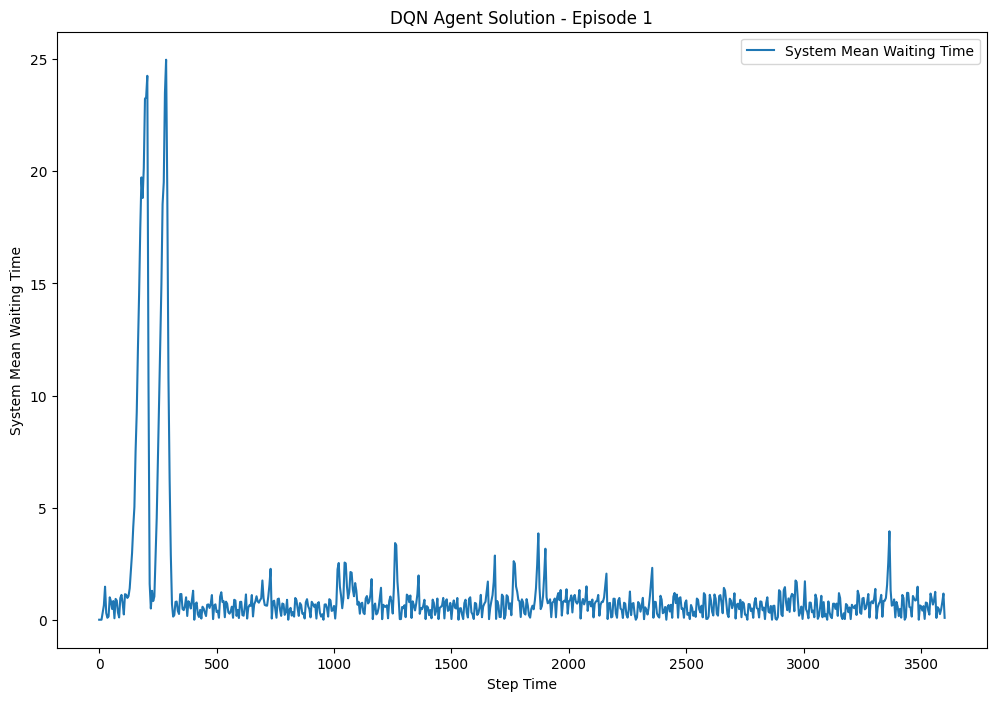

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


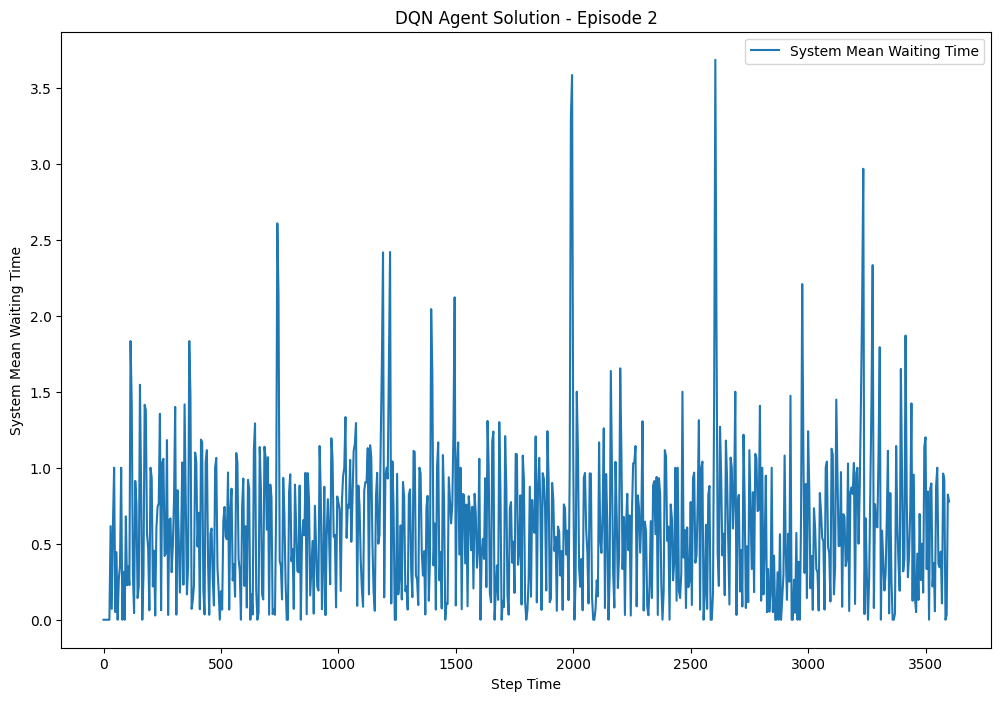

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


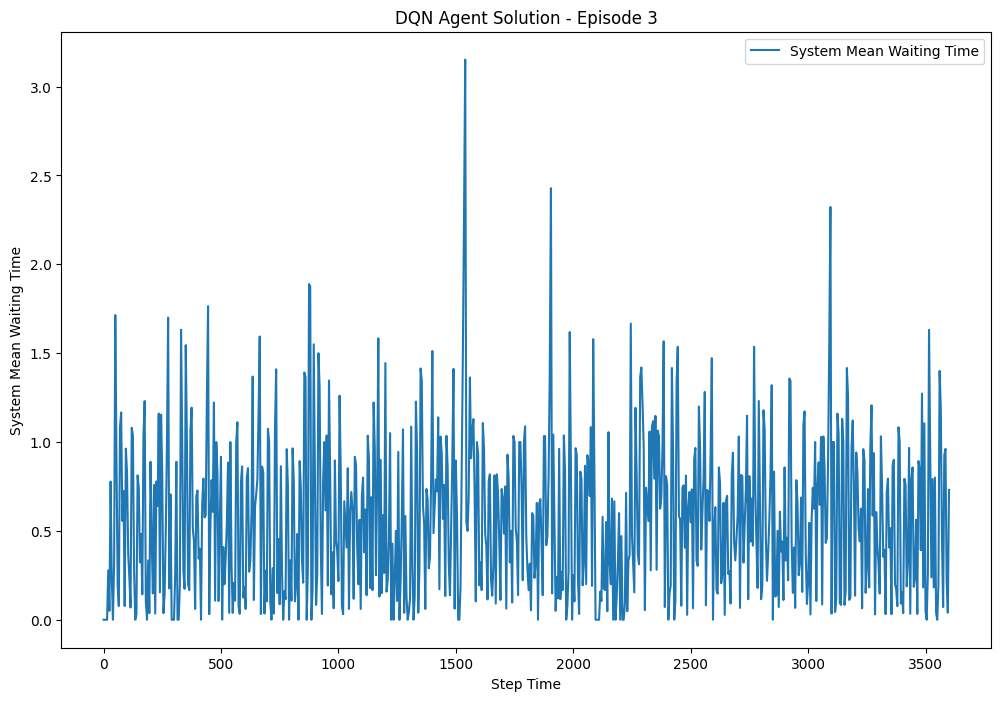

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


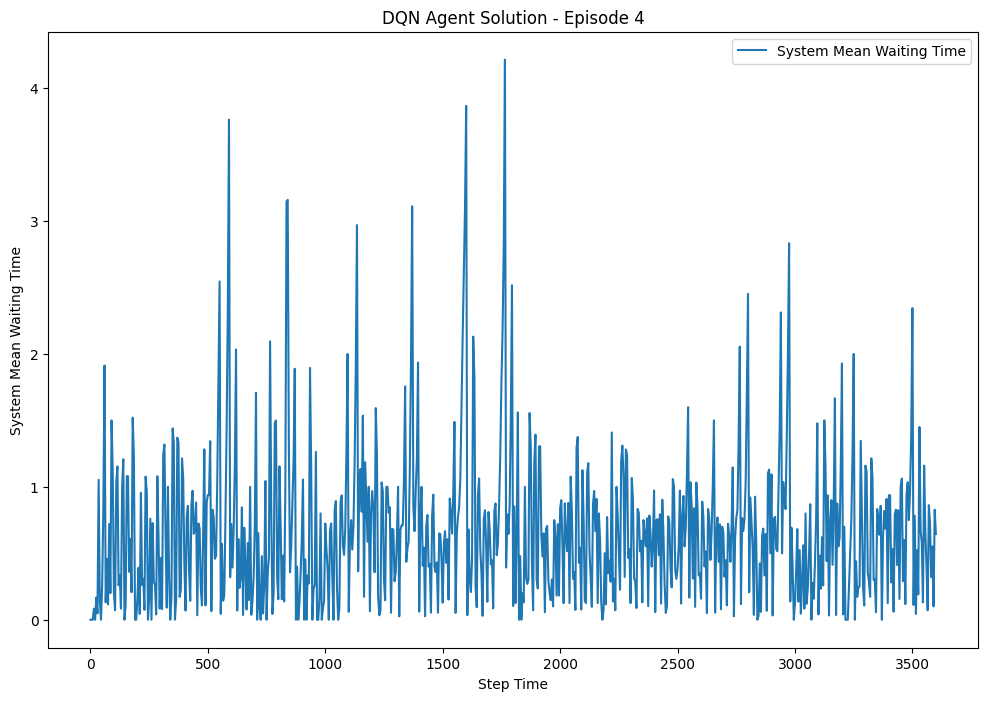

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


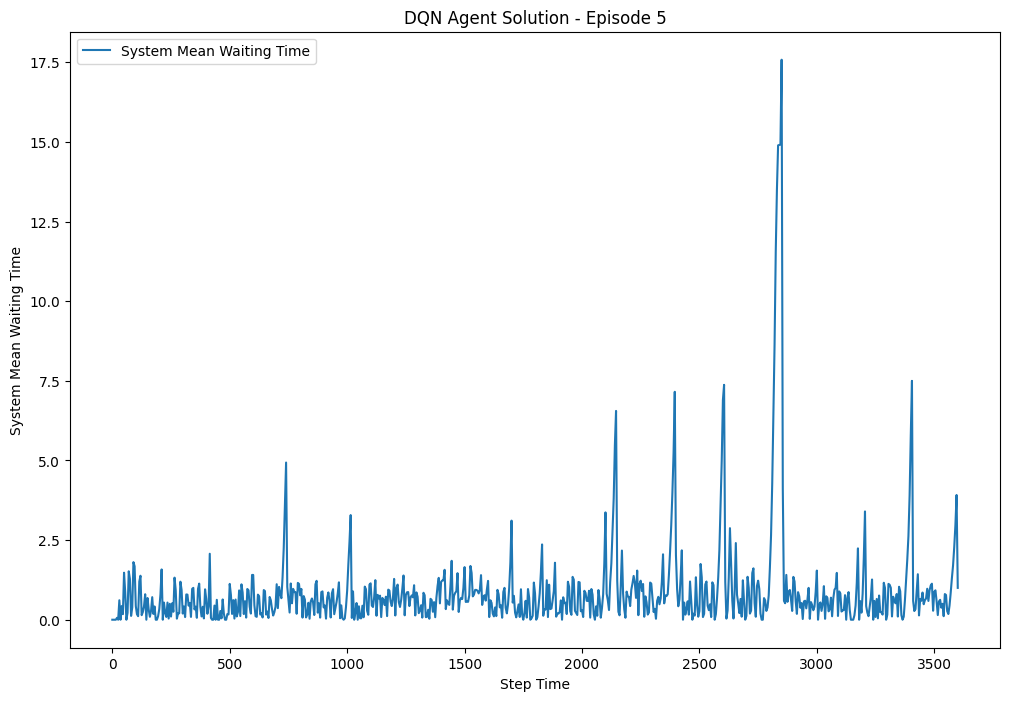

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


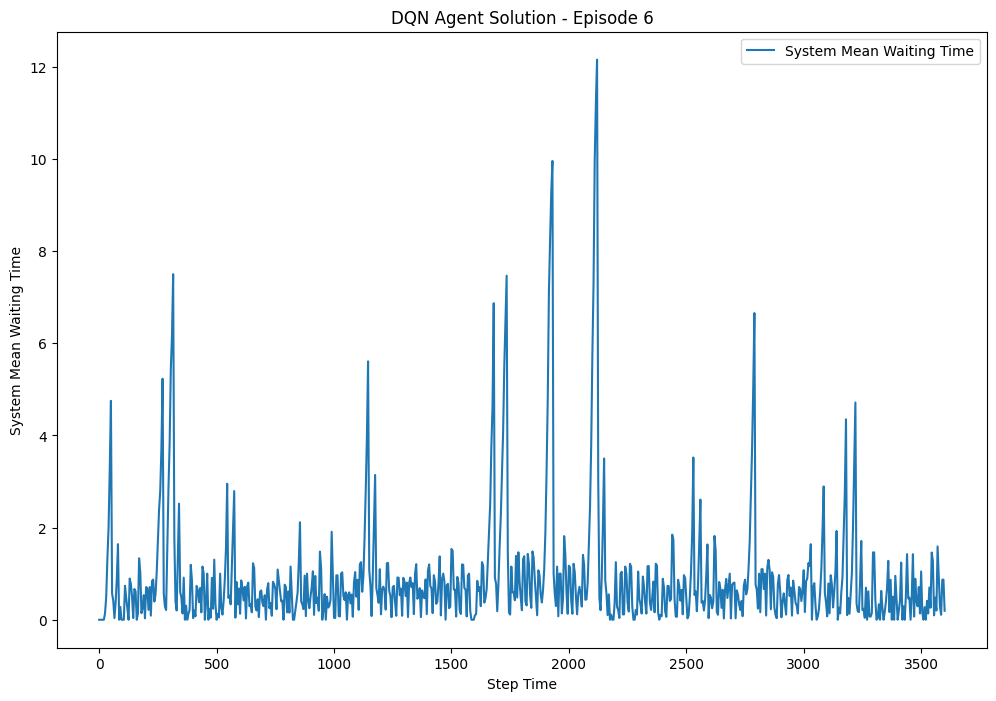

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


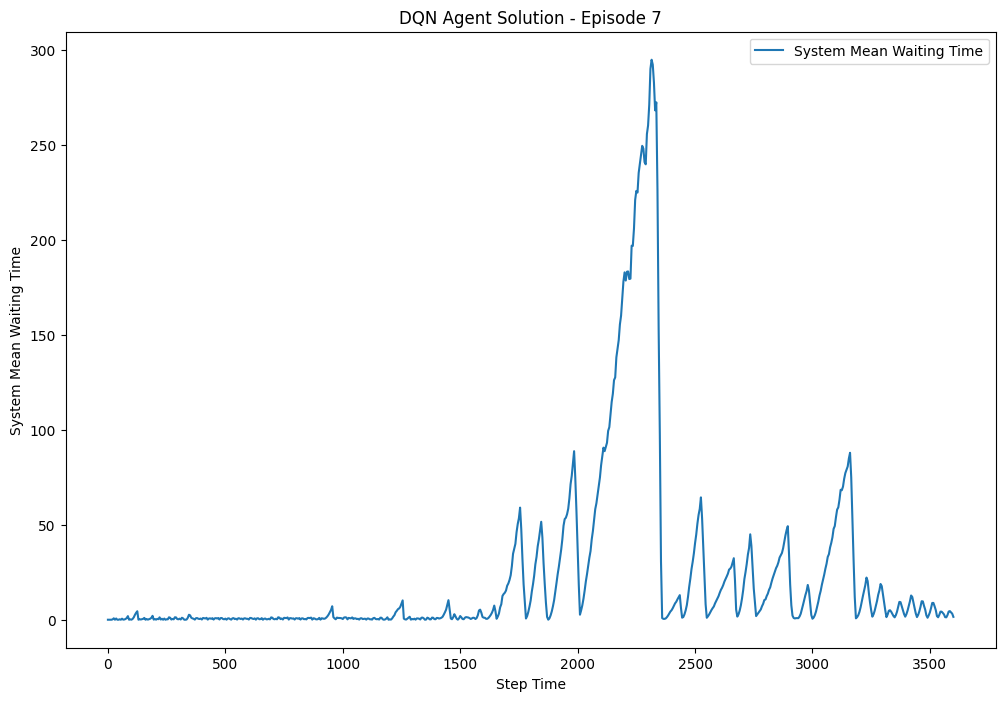

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


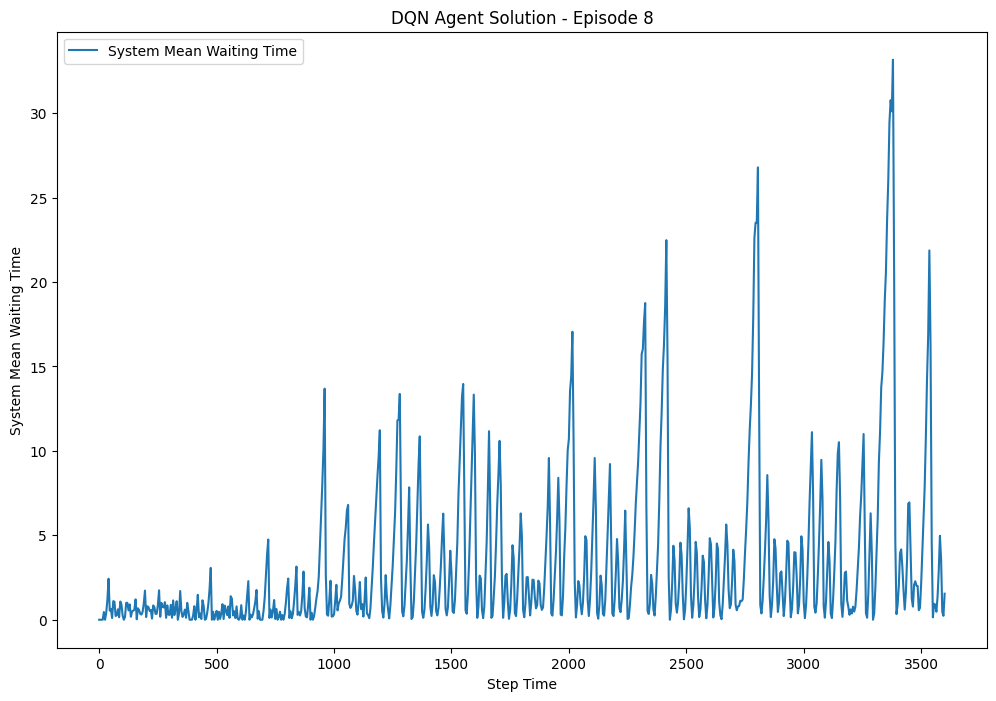

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


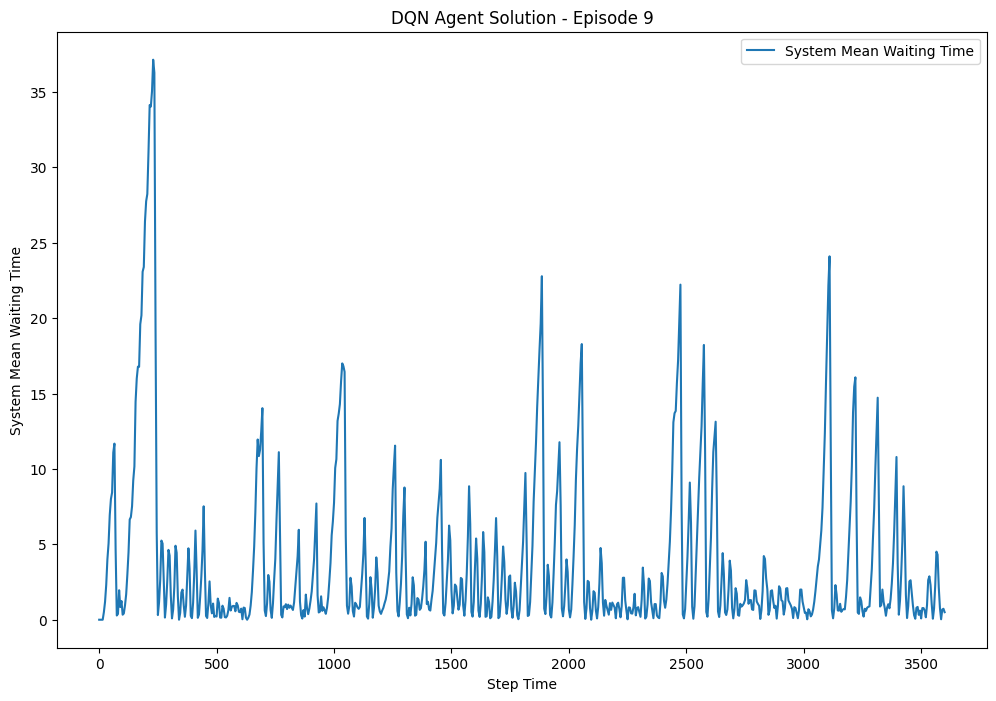

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


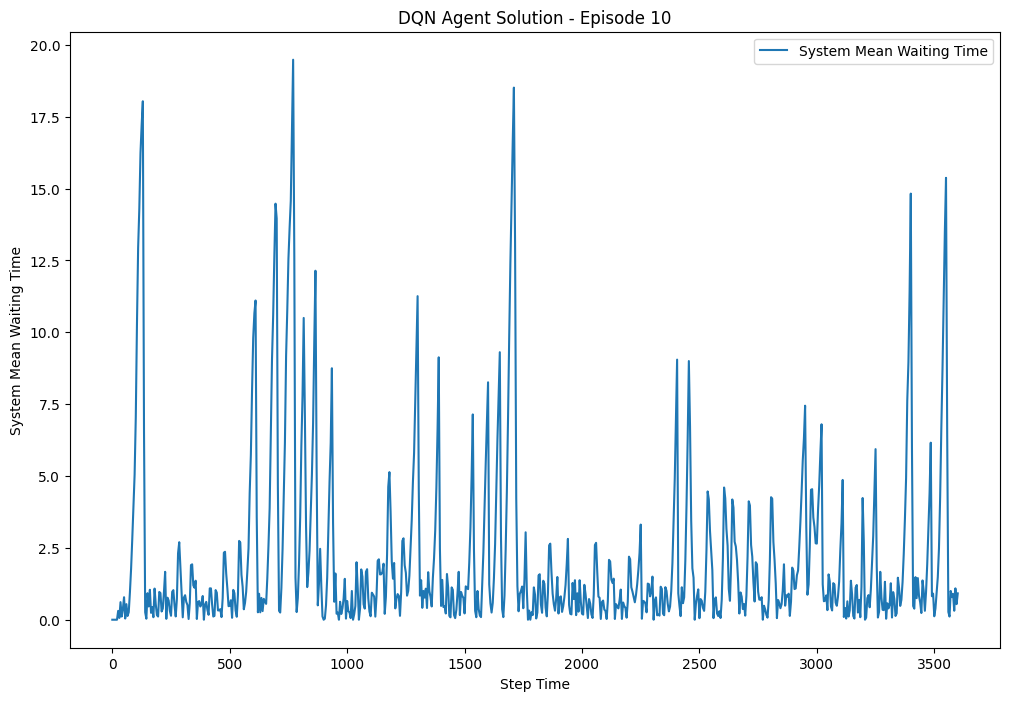

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


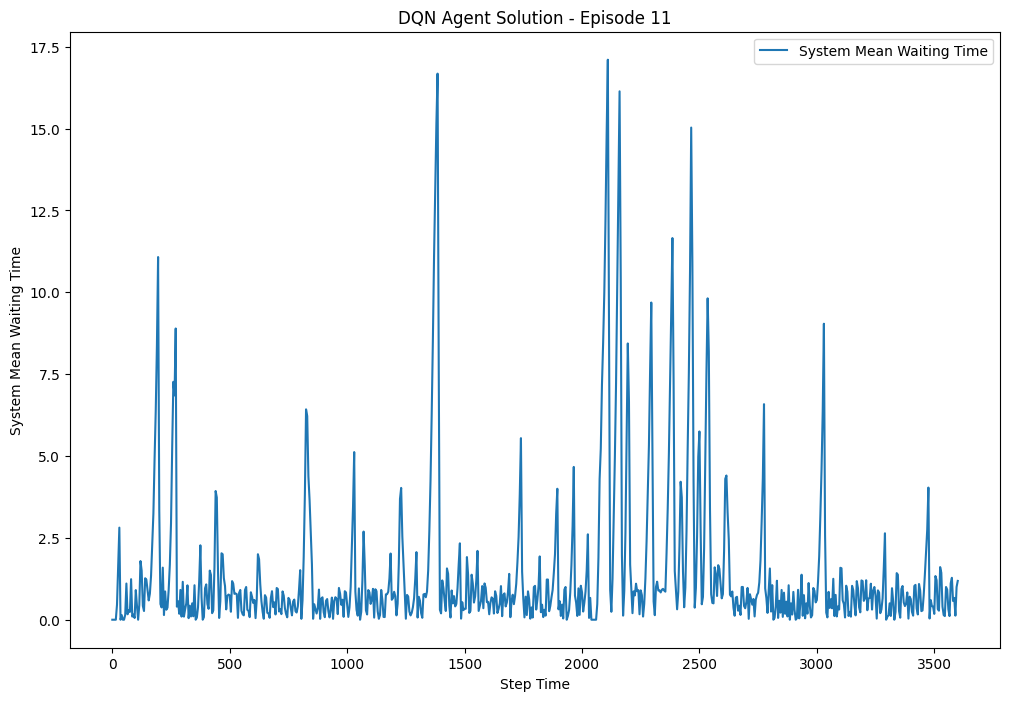

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


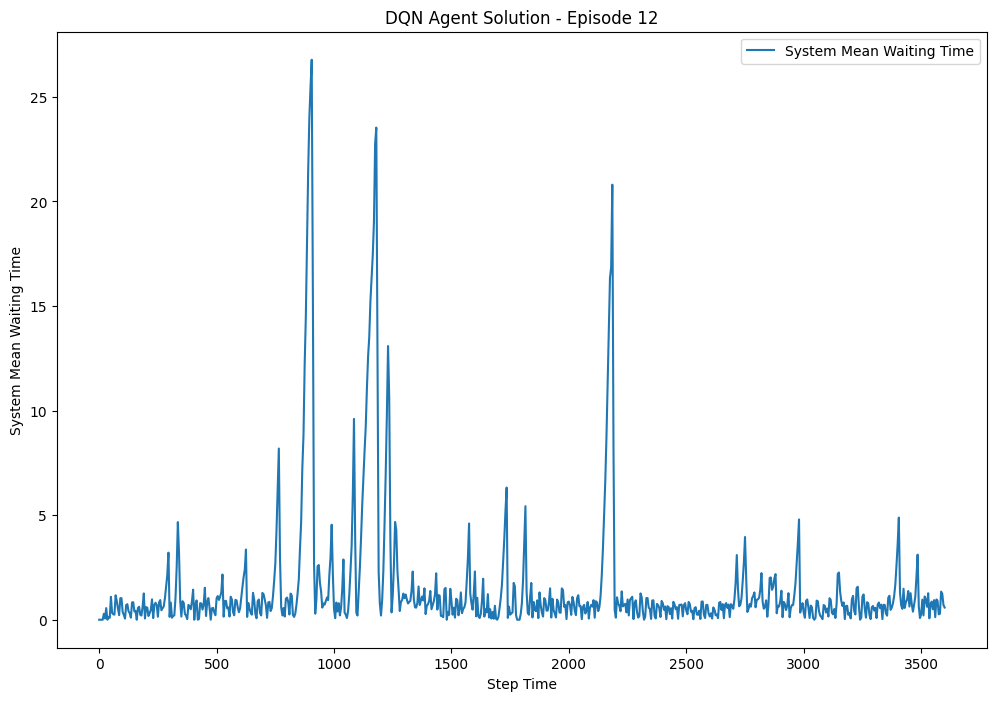

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


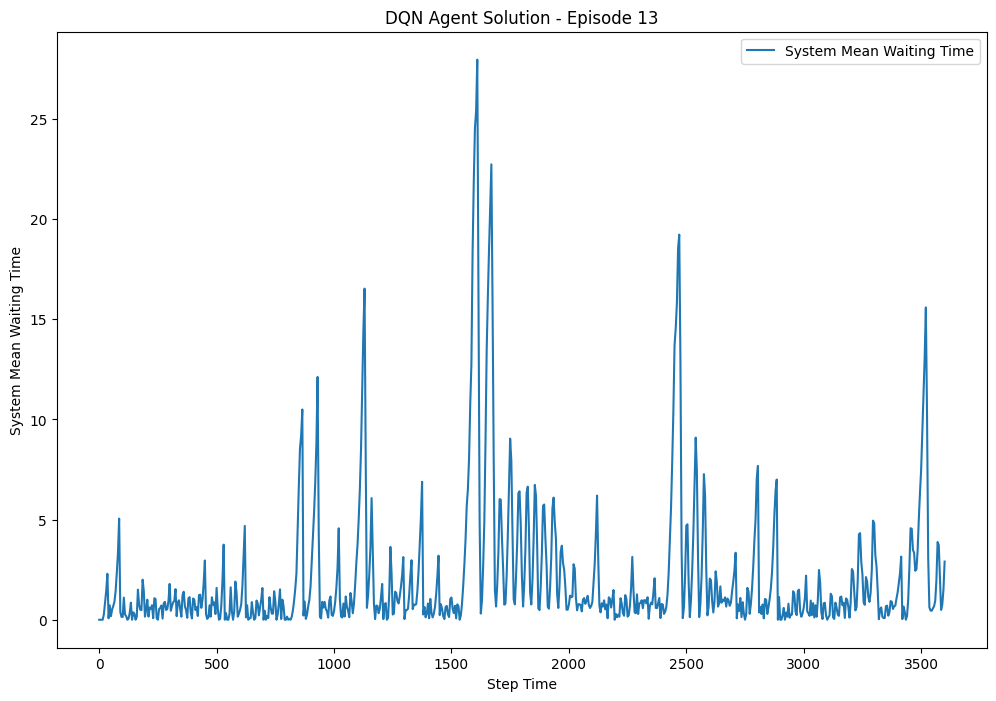

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


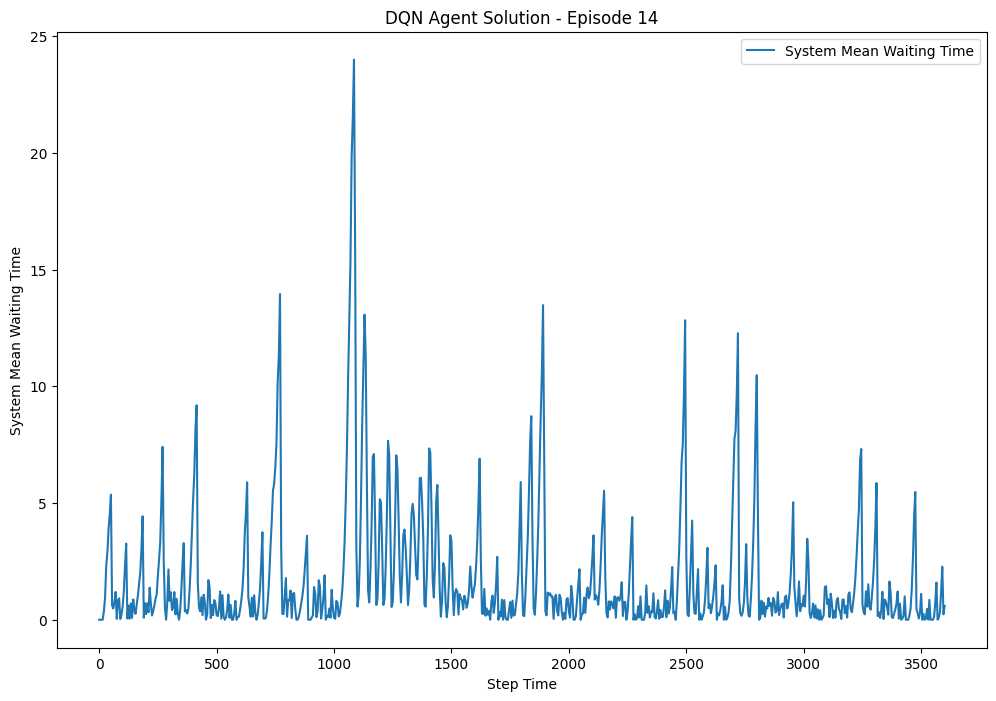

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


X Fatal error.
X Fatal error.


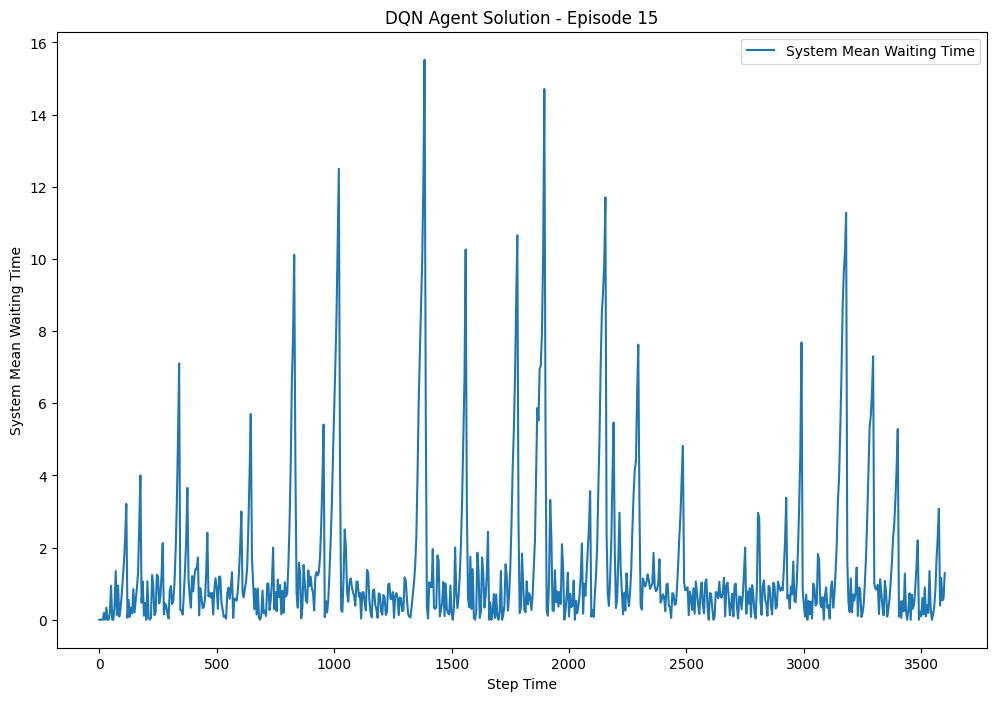

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


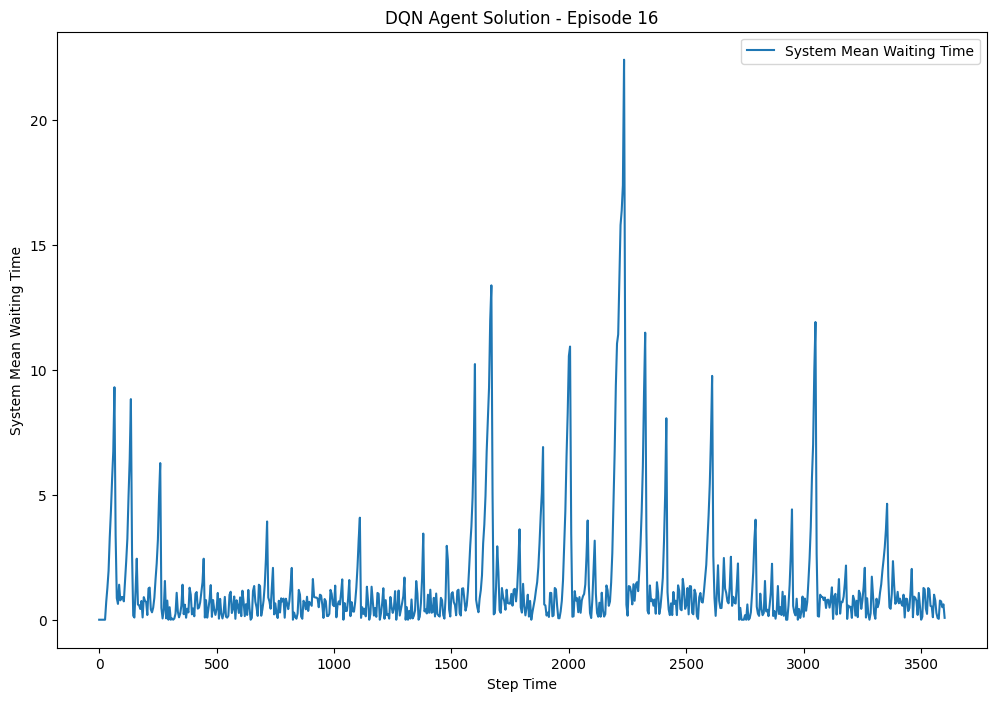

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


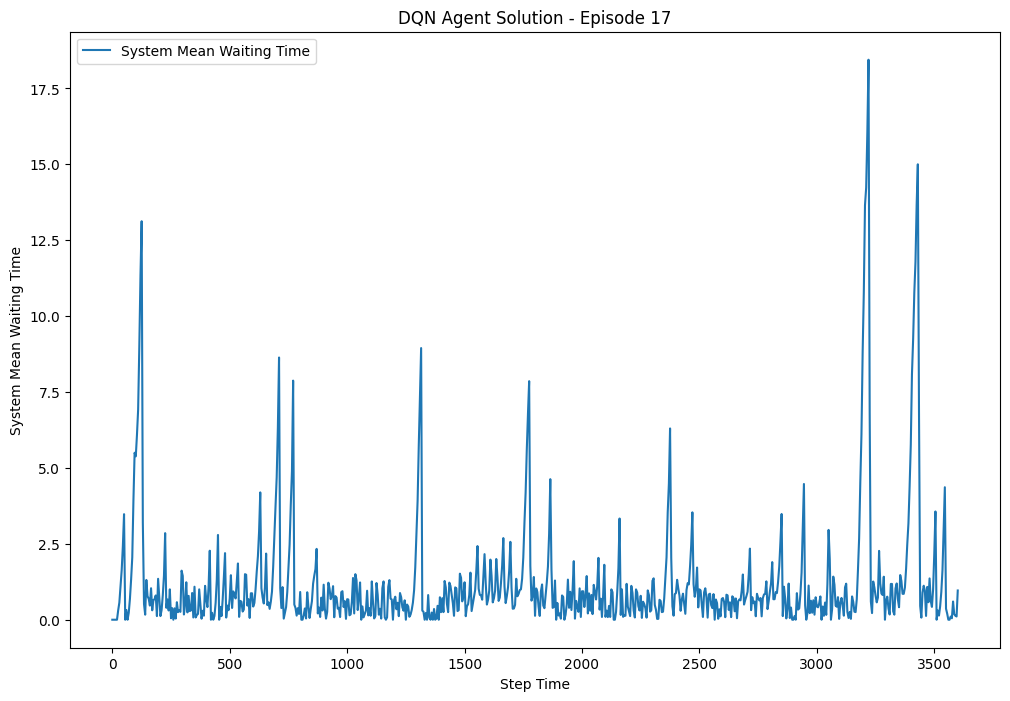

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


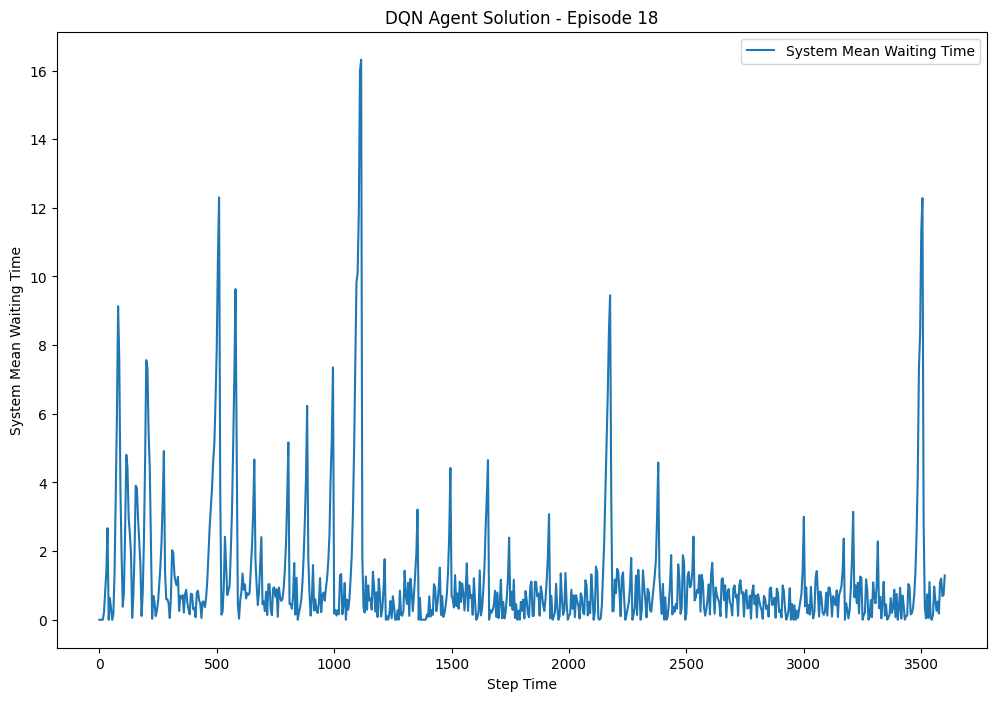

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


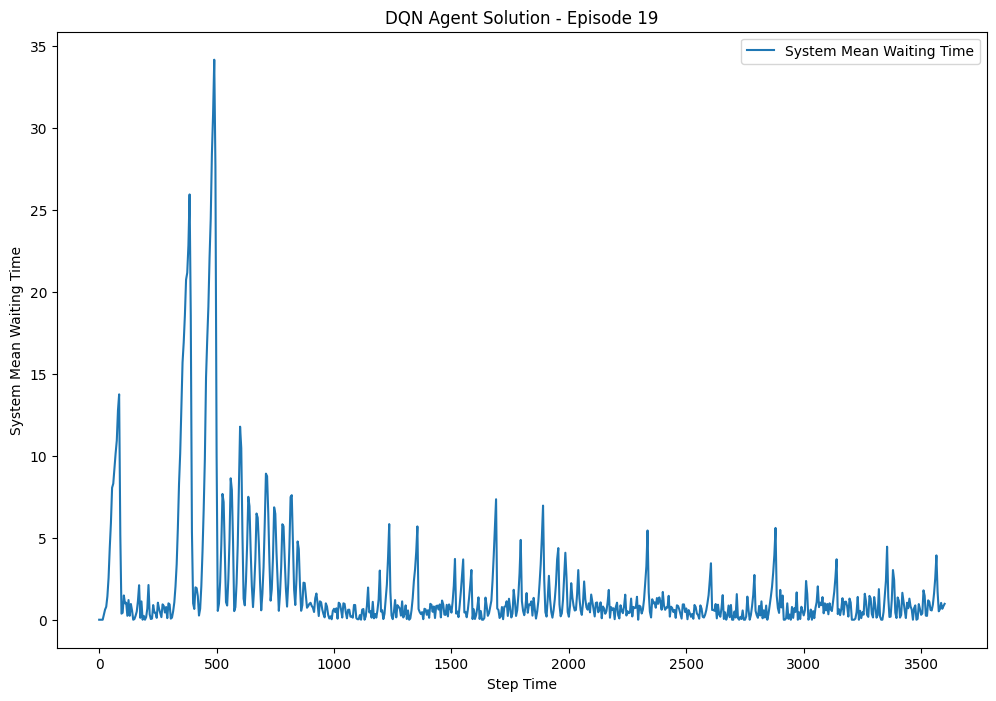

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


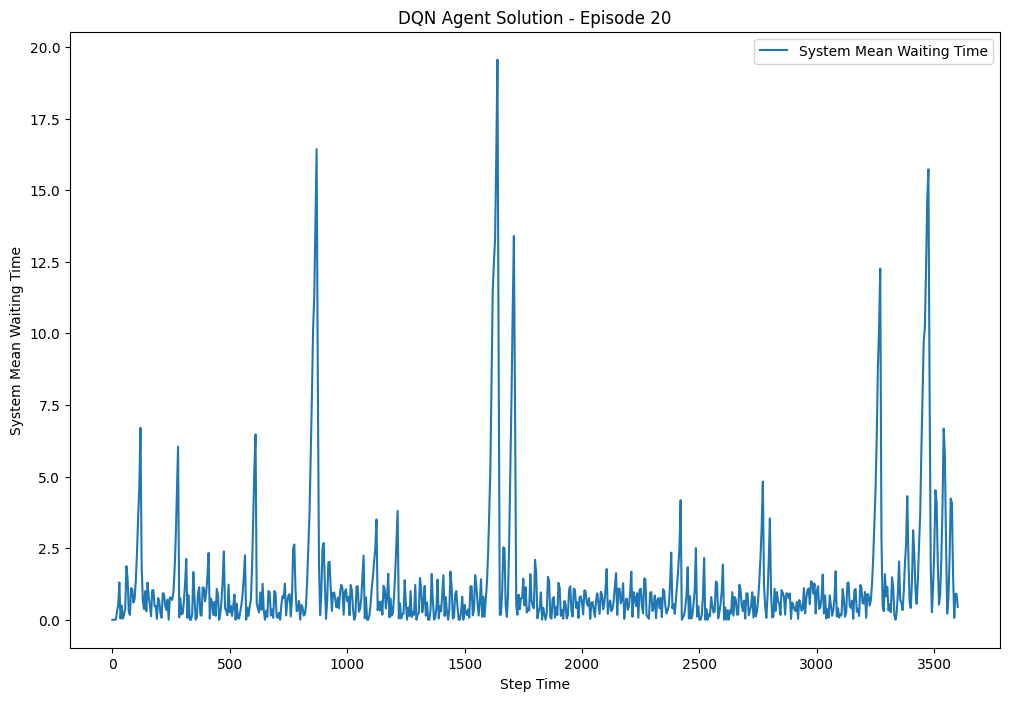

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


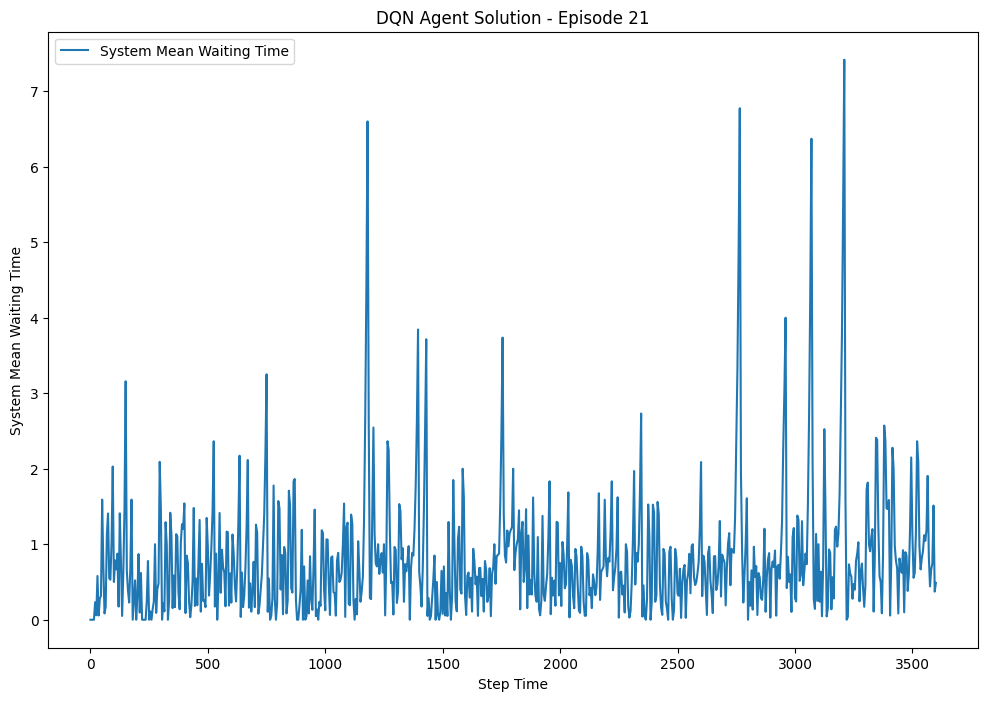

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


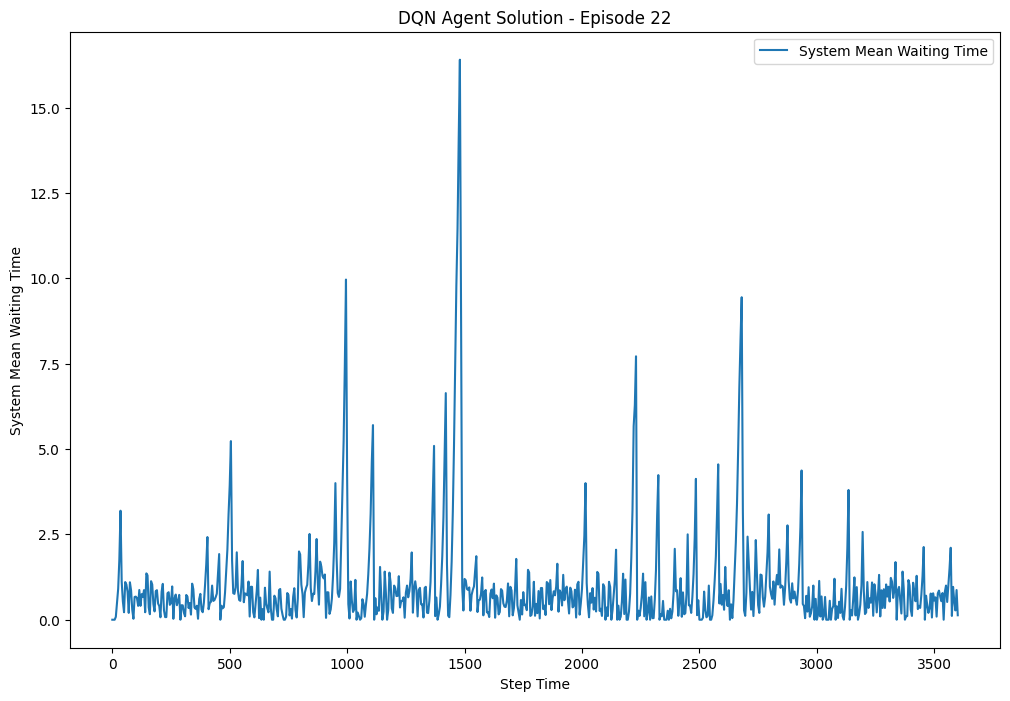

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


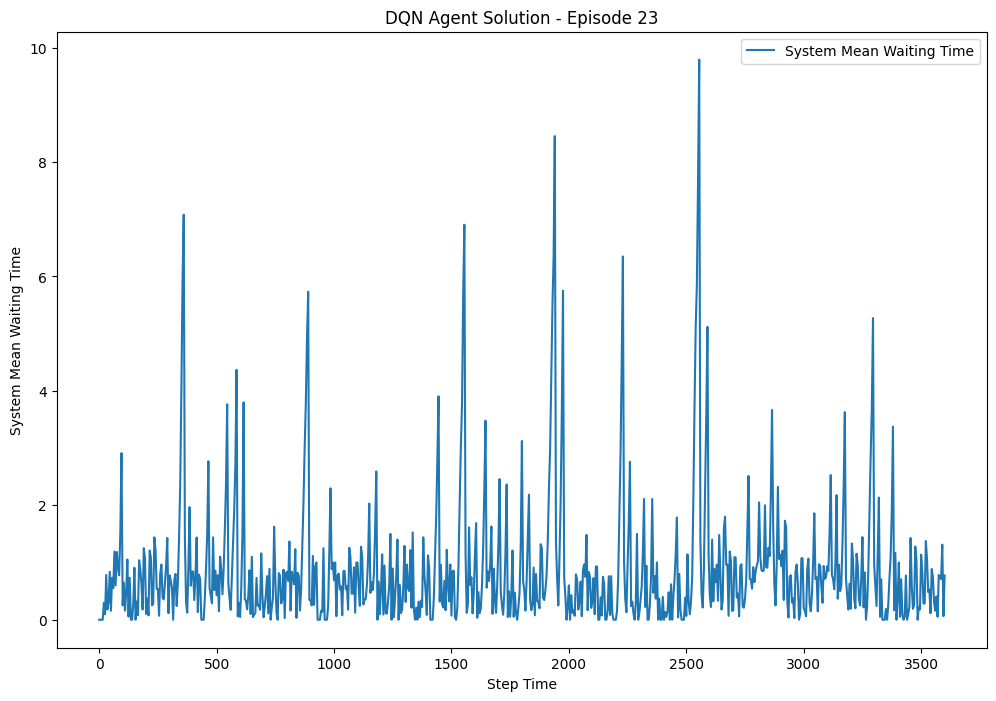

Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


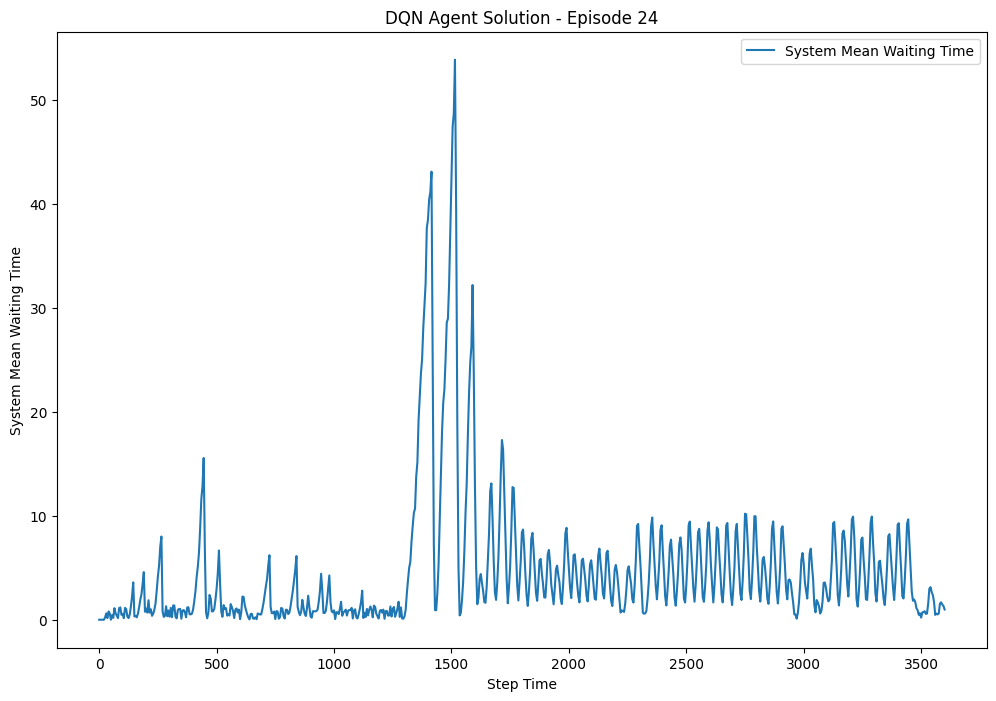

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics(file_path, title):
    data = pd.read_csv(file_path)
    print("Columns in the CSV:", data.columns)
    
    if 'step' not in data.columns or 'system_mean_waiting_time' not in data.columns:
        raise KeyError("CSV file does not contain required columns: 'step' and 'system_mean_waiting_time'")
    
    plt.figure(figsize=(12, 8))
    plt.plot(data['step'], data['system_mean_waiting_time'], label='System Mean Waiting Time')
    plt.xlabel('Step Time')
    plt.ylabel('System Mean Waiting Time')
    plt.title(title)
    plt.legend()
    plt.show()

def visualize_results():
    for episode in range(1, 25):  # Assuming episodes are numbered from 1 to 24
        file_path = f"/Users/md/Desktop/sumo-rl/outputs/single-intersection/dqn_20240531_152655.csv_conn2_ep{episode}.csv"
        title = f"DQN Agent Solution - Episode {episode}"
        plot_metrics(file_path, title)

if __name__ == "__main__":
    visualize_results()


Columns in the CSV: Index(['step', 'system_total_stopped', 'system_total_waiting_time',
       'system_mean_waiting_time', 'system_mean_speed', 't_stopped',
       't_accumulated_waiting_time', 't_average_speed', 'agents_total_stopped',
       'agents_total_accumulated_waiting_time'],
      dtype='object')


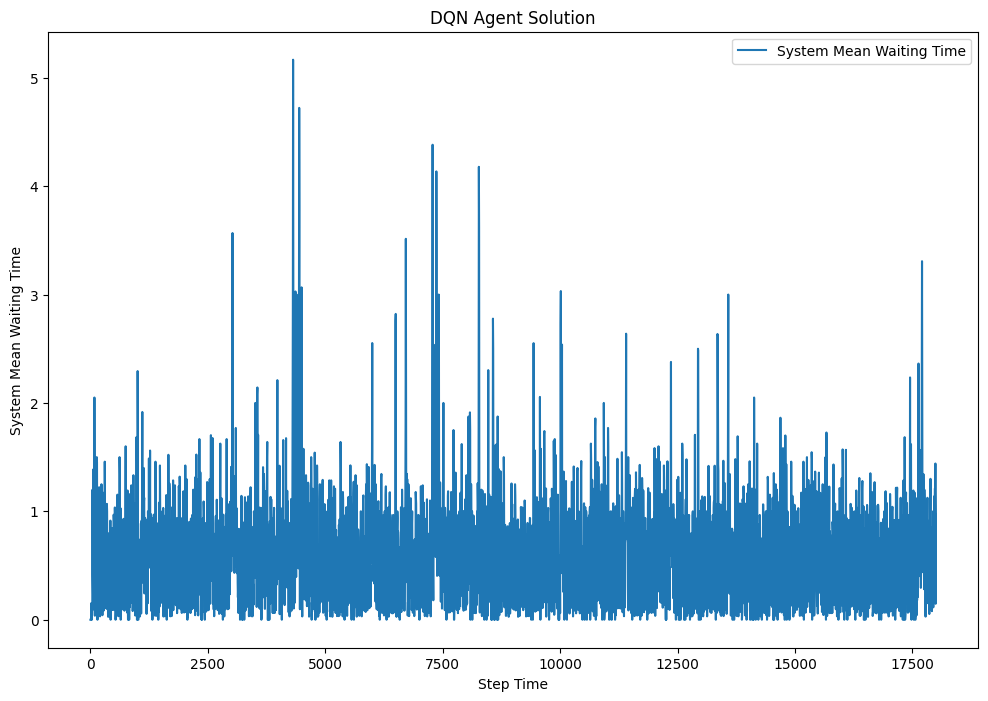

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics(file_path, title):
    data = pd.read_csv(file_path)
    print("Columns in the CSV:", data.columns)
    
    if 'step' not in data.columns or 'system_mean_waiting_time' not in data.columns:
        raise KeyError("CSV file does not contain required columns: 'step' and 'system_mean_waiting_time'")
    
    plt.figure(figsize=(12, 8))
    plt.plot(data['step'], data['system_mean_waiting_time'], label='System Mean Waiting Time')
    plt.xlabel('Step Time')
    plt.ylabel('System Mean Waiting Time')
    plt.title(title)
    plt.legend()
    plt.show()

def visualize_results():
    # Naive solution
    # plot_metrics("outputs/2way-single-intersection/naive.csv", "Naive Fixed-Time Solution")

    # DQN agent solution
    plot_metrics("/Users/md/Desktop/sumo-rl/outputs/2way-single-intersection/dqn_conn10_ep24.csv", "DQN Agent Solution")

if __name__ == "__main__":
    visualize_results()


# Run the trained DQN agent and visualize the results


In [ ]:
if __name__ == "__main__":
    print("Connecting to SUMO server...")
    traci_connection = traci.connect(port=65533)
    print("Connected to SUMO server")

    env = SumoEnvironment(
        net_file="/Users/md/Desktop/sumo-rl/nets/single-intersection/single-intersection.net.xml",
        route_file="/Users/md/Desktop/sumo-rl/nets/single-intersection/single-intersection.rou.xml",
        out_csv_name="outputs/2way-single-intersection/dqn",
        single_agent=True,
        use_gui=True,
        num_seconds=3600,
        max_depart_delay=0)
    
    model = DQN.load("path_to_trained_model.zip")

    obs = env.reset()
    for _ in range(env.simulation_steps):
        action, _ = model.predict(obs)
        obs, rewards, dones, info = env.step(action)

    visualize_results()

# Creating and Exporting Videos

In [14]:
def create_video(output_path, title):
    import imageio
    from IPython.display import Video

    images = []
    for file_name in sorted(os.listdir(output_path)):
        if file_name.endswith(".png"):
            file_path = os.path.join(output_path, file_name)
            images.append(imageio.imread(file_path))
    imageio.mimsave(f'{title}.mp4', images, fps=10)
    return Video(f'{title}.mp4')

if __name__ == "__main__":
    create_video("outputs/2way-single-intersection/naive_images", "Naive Solution")
    create_video("outputs/2way-single-intersection/dqn_images", "DQN Agent Solution")


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/2way-single-intersection/naive_images'